# Spherical ICET

In [1]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf
from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

Autosaving every 180 seconds


In [167]:
from ICET_spherical import ICET

# init KITTI dataset -----------------------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
idx = 138
# drive = '0093'
# idx = 220
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(idx) # Each scan is a Nx4 array of [x,y,z,reflectance]
c1 = velo1[:,:3]
# c1 = c1[c1[:,2] > -1.5] #ignore ground plane
velo2 = dataset.get_velo(idx+1) # Each scan is a Nx4 array of [x,y,z,reflectance]
c2 = velo2[:,:3]
# c2 = c2[c2[:,2] > -1.5] #ignore ground plane
# ------------------------------------------------------------------------------------

# ## load custom point cloud geneated in matlab------------------------------------------
# c1 = np.loadtxt("scene1_scan1.txt", dtype = float)
# # c2 = c1 + np.array([2.0, 0.2, 0])
# c2 = c1 + np.array([0.1, 0., 0.])

# # c1 = c1[c1[:,2] > -1.5] #ignore ground plane
# # c2 = c2[c2[:,2] > -1.5] #ignore ground plane
# ## ------------------------------------------------------------------------------------

# #single distinct cluster---------------------------------------------------------------
# c1 = np.random.randn(3000,3)*tf.constant([0.04,0.3,0.3]) + tf.constant([6.,0.,0.])
# c2 = np.random.randn(3000,3)*tf.constant([0.04,0.3,0.3]) + tf.constant([6.,0.,0.]) - np.array([0., 0.25, 0.0])
# # # c2 = c1 - np.array([0.1, 0.3, 0.0])
# # -------------------------------------------------------------------------------------

# D = True
D = False
X = tf.constant([0., 0., 0., 0., 0., 0.])
it1 = ICET(cloud1 = c1, cloud2 = c2,  fid = 50, draw = False, x0 = X, niter = 20, group= 2, RM = True)
# it2 = ICET(cloud1 = it1.cloud1_static, cloud2 = c2, fid = 50, niter = 20, draw = True, group = 2, RM = False)


if D:
    ViewInteractiveWidget(it2.plt.window)


 estimated solution vector X: 
 tf.Tensor([0. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.21611415 -0.06910128 -0.01759244 -0.00131431 -0.00180877  0.0054036 ], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.3438086  -0.04692348 -0.00454387 -0.00159386 -0.00134025  0.00865036], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.42345417 -0.03078176 -0.00212256 -0.00235147 -0.00125734  0.01061012], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor(
[ 4.8251358e-01 -1.9791001e-02  4.8019923e-04 -2.3804246e-03
 -8.2501036e-04  1.1713945e-02], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.5160122  -0.01302413  0.00118441 -0.00251665 -0.00071625  0.01239918], shape=(6,), dtype=float32)

 estimated solution vector X: 
 tf.Tensor([ 0.53542274 -0.00832614  0.00178975 -0.00254656 -0.00065302  0.01280473], shape=(6,), dtype=float32)

 estimated solutio

In [158]:
t1 = tf.constant([1, 4, 5, 6, 7])[None, :]
print(t1)
t2 = tf.constant([0, 1, 3, 4, 5, 8, 11])[None, :]
print(t2)

combined = tf.sets.union(t1, t2).values
print(combined)


tf.Tensor([[1 4 5 6 7]], shape=(1, 5), dtype=int32)
tf.Tensor([[ 0  1  3  4  5  8 11]], shape=(1, 7), dtype=int32)
tf.Tensor([ 0  1  3  4  5  6  7  8 11], shape=(9,), dtype=int32)


## Identify outlier cells

<IPython.core.display.Javascript object>


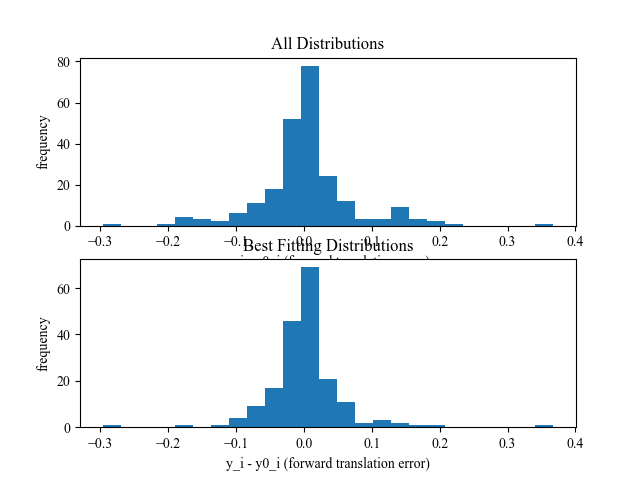

tf.Tensor([234], shape=(1,), dtype=int32)

 before:
mean tf.Tensor(0.002873197, shape=(), dtype=float32)
standard deviation tf.Tensor(0.070456736, shape=(), dtype=float32)
tf.Tensor([190], shape=(1,), dtype=int32)

 after:
mean tf.Tensor(0.0020716786, shape=(), dtype=float32)
standard deviation tf.Tensor(0.057207864, shape=(), dtype=float32)


Text(0.5, 1.0, 'Best Fitting Distributions')

In [172]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
nbins = 25
nstd = 2

# print(it.dx_i[:,0])
# print(tf.math.reduce_sum(it.dx_i, axis = 0))
# print(it.W)
# print(it.H)
# print(it.residuals[:,0])

component = it1.residuals_full[:,1]
print(tf.shape(component))
# print(component)

print("\n before:")
mu = tf.math.reduce_mean(component)
print("mean", mu)
sigma = tf.math.reduce_std(component)
print("standard deviation", sigma)
bad_idx = tf.where( tf.math.abs(component) > mu + nstd*sigma )
# print("bad idx", bad_idx)
good_idx = tf.where( tf.math.abs(component) < mu + nstd*sigma )
# print(tf.gather(component, bad_idx))
# ax.hist(it.dx_i[:,0], nbins);
ax[0].hist(component, nbins);
ax[0].set_xlabel("y_i - y0_i (forward translation error)")
ax[0].set_ylabel("frequency")
ax[0].set_title("All Distributions")

#test to make sure outliers are being removed correctly
component = it1.residuals[:,1]
print(tf.shape(component))
# print(component)

print("\n after:")
mu = tf.math.reduce_mean(component)
print("mean", mu)
sigma = tf.math.reduce_std(component)
print("standard deviation", sigma)

ax[1].hist(component, nbins);
ax[1].set_xlabel("y_i - y0_i (forward translation error)")
ax[1].set_ylabel("frequency")
ax[1].set_title("Best Fitting Distributions")


In [60]:
import tensorflow_probability as tfp

# print(it.residuals_full[:,0])
edges = tf.linspace(-1.,1.,30)
# print(edges)
print(edges)

bins_soln = tfp.stats.find_bins(it.residuals_full[:,0], edges)
# print(bins_soln)

good_idx = tf.where(bins_soln == 14)
bad_idx = tf.where(bins_soln == 14)
# print(bad_idx)
# print(good_idx)
# print(tf.gather(it.residuals_full[:,0], good_idx))


tf.Tensor(
[-1.         -0.9310345  -0.86206895 -0.79310346 -0.7241379  -0.6551724
 -0.5862069  -0.51724136 -0.44827586 -0.37931037 -0.31034482 -0.24137932
 -0.17241383 -0.10344827 -0.03448278  0.03448272  0.10344827  0.17241383
  0.24137926  0.31034482  0.37931037  0.4482758   0.51724136  0.5862069
  0.65517235  0.7241379   0.79310346  0.862069    0.93103445  1.        ], shape=(30,), dtype=float32)
14


In [17]:
a = tf.constant([[5, 6, 7, 8]])
b = tf.constant([[8, 7, 10]])
print(tf.sets.difference(a,b).values)

tf.Tensor([5 6], shape=(2,), dtype=int32)


## Identify Useful Clusters

tf.Tensor([178 178 178 ...   0   0   0], shape=(112514,), dtype=int32)

 occupied_spikes 
 tf.Tensor(
[178 185 192 199 206 205 212 213 220 227 234 241 248 247 254 255 262 261
 269 276 283 290 297 304 311 310 317 318 325 324 332 339 346   3  10  17
  24  31  30  38  45  52  59  66  73  80  87  94 108 115 122 129 136 143
 150 157 164 171 101 277 284 179 186 200 207 214 221 228 235 242 270 291
 298 305 312 319 326 333 340 347   4  11  18  25  74  81  88  95 102 109
 116 123 130 137 144 151 158 165 172 193  32  39  46  53  67 263  60 249
 256 180 187 194 201 208 215 222 229 236 243 264 271 278 285 292 299 306
 313 320 327 334 341 348   5  12  19  26  33  40  47  54  61  68  75  82
  89  96 103 110 117 124 131 138 145 152 159 166 173 250 257 181 188 195
 202 209 216 223 230 237 244 251 258 265 279 286 293 300 307 314 321 328
 335 342 349   6  13  20  27  34  41  48  55  62  69  76  83  90  97 104
 125 132 139 146 153 160 167 174 118   0], shape=(208,), dtype=int32)


<IPython.core.display.Javascript object>


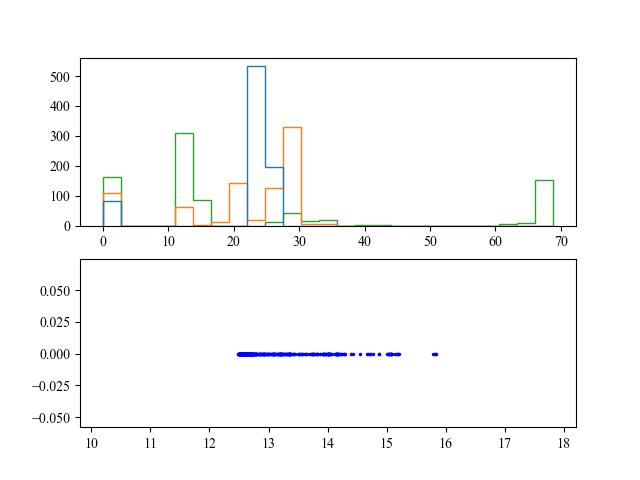

b1 tf.Tensor(-488.68265, shape=(), dtype=float32)
b2 tf.Tensor(486.79535, shape=(), dtype=float32)
b1 tf.Tensor(-493.62613, shape=(), dtype=float32)
b2 tf.Tensor(0.10814619, shape=(), dtype=float32)
b1 tf.Tensor(-493.7589, shape=(), dtype=float32)
b2 tf.Tensor(0.28889656, shape=(), dtype=float32)

 Bounds 
 tf.Tensor(
[[20.68901062 28.40927124]
 [10.75256729 13.1968956 ]
 [10.48655128 15.49582672]], shape=(3, 2), dtype=float64)


In [81]:
from utils import get_cluster

#index of spike that each of the points from cloud 1 is occupying
print(it.bins_spike)

occupied_spikes, idxs = tf.unique(it.bins_spike)
print("\n occupied_spikes \n", occupied_spikes)
temp =  tf.where(it.bins_spike == occupied_spikes[:,None])
rag = tf.RaggedTensor.from_value_rowids(temp[:,1], temp[:,0])
idx_by_rag = tf.gather(it.cloud1_tensor_spherical[:,0], rag)

# rads = idx_by_rag[50,:] #single element from ragged tensor
rads = tf.transpose(idx_by_rag.to_tensor()[:3,:])
# rads = tf.transpose(idx_by_rag.to_tensor())
# print(rads) #starts out unordered

# #_________________________________________________________________
fig, ax = plt.subplots(2,1)
nbins = 25
ax[0].hist(rads.numpy(), nbins, histtype = 'step');
yax = tf.ones(tf.shape(rads), tf.float32) #plots everything on top of eachother
yax = yax * tf.cast(tf.linspace(1, 0, tf.shape(rads)[1]), tf.float32)
# print(tf.linspace(0, 1, tf.shape(rads)[1])[:,None] )
ax[1].plot(rads,yax, 'b.', markersize = 3)
# #_________________________________________________________________
""
bounds = get_cluster(rads)
print("\n Bounds \n", bounds)


In [ ]:
a = np.zeros([1,2])
b = np.ones([3,2])
print(np.append(b, a, axis = 0))

In [ ]:
edges_r = bounds[6,:]
print(edges_r)
pts = tf.cast(tf.convert_to_tensor(c1[:,1]), tf.float64)
print(pts)

bins_r = tfp.stats.find_bins(pts, edges_r)
print(bins_r)
#get rid of NaNs
nonnan = 1 - tf.cast(tf.math.is_nan(bins_r), tf.float32)
idxnonan = tf.where(nonnan == 1)
print(tf.gather(bins_r, idxnonan))

In [252]:
#get true transformation between frames
from metpy.calc import lat_lon_grid_deltas
idx = 145
poses0 = dataset.oxts[idx] #<- ID of 1st scan
poses1 = dataset.oxts[idx+1] #<- ID of 2nd scan
lat0 = poses0.packet.lat
lon0 = poses0.packet.lon
alt0 = poses0.packet.alt
lat1 = poses1.packet.lat
lon1 = poses1.packet.lon
alt1 = poses1.packet.alt

# print(lat0)
# print(lon0)

dx_oxts, dy_oxts = lat_lon_grid_deltas(np.array([lon0,lon1]), np.array([lat0, lat1]))
# print(dx_oxts, dy_oxts) 
dx_oxts = dx_oxts[0,0].magnitude
dy_oxts = dy_oxts[0,0].magnitude
dz_oxts = (alt0-alt1)
droll_oxts = (poses0.packet.roll - poses1.packet.roll)
dpitch_oxts = (poses0.packet.pitch - poses1.packet.pitch)
dyaw_oxts = (poses0.packet.yaw - poses1.packet.yaw)

rot = poses1.T_w_imu[:3,:3] #trying this

dxyz_oxts = np.array([[dx_oxts, dy_oxts, dz_oxts]])
dxyz_lidar = dxyz_oxts.dot(rot)
print(dxyz_lidar)

dt = 0.10
from_vel = np.array([[poses1.packet.vf*dt, poses1.packet.vl*dt, poses1.packet.vu*dt, -poses1.packet.wf*dt, -poses1.packet.wl*dt, -poses1.packet.wu*dt]])
print(from_vel)

# print(poses1.packet.vel_accuracy)
print((dataset.timestamps[idx+1] - dataset.timestamps[idx]).microseconds/(10e5))

# # print(np.shape(dataset.timestamps)[0])
# # tvec = np.zeros(np.shape(dataset.timestamps)[0])
# tvec = np.zeros(149)
# # for i in range(np.shape(dataset.timestamps)[0] - 1):
# for i in range(149):
# #     print((dataset.timestamps[i+1] - dataset.timestamps[i]).microseconds/(10e5))
#     tvec[i] = (dataset.timestamps[i+1] - dataset.timestamps[i]).microseconds/(10e5)
# print(tvec)

# fig, ax = plt.subplots()
# ax.plot(tvec)

[[ 6.84060834e-01 -4.44028064e-04  1.70165740e-02]]
[[ 0.62739531  0.00524947 -0.00902339  0.00093502 -0.00164804 -0.01286043]]
0.110049


In [ ]:
#test batch rotation matrix conversions
from utils import R_tf

print(R_tf(tf.Variable([[0., 0., 1.]])), "\n")

angs = tf.Variable([[0., 0., 1.], [0., 0., 1.]])
# angs = tf.Variable([[0., 0., 1.]])
print(angs)

rots = R_tf(angs) 
print(rots)


In [ ]:
#pad tensors to get them to the same length
#to fix bug in get_U_and_L()

t1 = tf.ones([8,3], tf.int32)
print(t1)
t2 = tf.ones([7,3], tf.int32)
print(t2)

bofa = tf.sets.intersection(t1, t2).values

In [ ]:
#test- workaround for in place tensor operations
indices = tf.cast(tf.constant([1, 2, 3, 5]), tf.int32)[:,None]
print("indices", indices)
updates = tf.ones(tf.shape(indices))
print("updates", updates)
shape = tf.constant([7, 1])
print("shape", shape)

b = tf.scatter_nd(indices, updates, shape)
print(b)


## Plot results of ICET estimates on KITTI lidar point clouds vs GPS/INS baseline

<IPython.core.display.Javascript object>


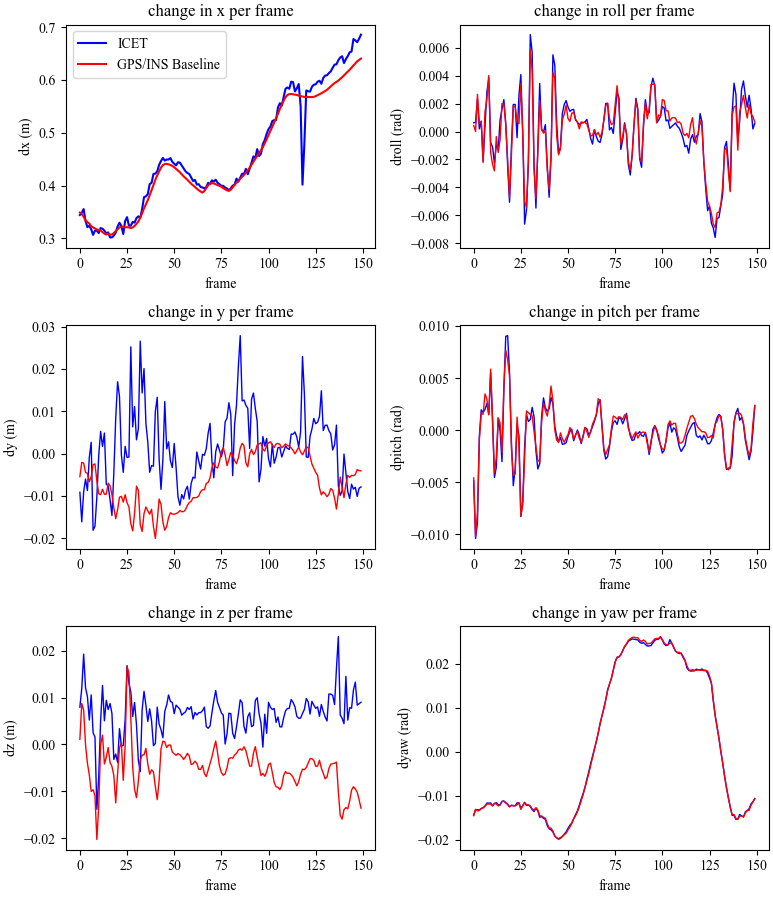

In [241]:
import matplotlib.pyplot as plt
font = {'fontname':'Times New Roman'}

OXTS_baseline = np.loadtxt("OXTS_baseline_v7.txt")
ICET_estimates = np.loadtxt("ICET_estimates_v7.txt")

OXTS_baseline[:,3:] = OXTS_baseline[:,3:]/0.1*0.1037
# OXTS_baseline = OXTS_baseline/0.1*0.1037

# ICET_estimates[:,0] = ICET_estimates[:,0]/tvec*0.1

#fix sign errors
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
style1 = 'b-'
style2 = 'r-'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(ICET_estimates[:,0], style1, label = 'ICET')
ax[0,0].plot(OXTS_baseline[:,0], style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,0], n),  style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(ICET_estimates[:,0], n),  style1, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per frame", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_xlabel("frame", **font)

ax[1,0].plot(ICET_estimates[:,1], style1, lw = 1)
ax[1,0].plot(-OXTS_baseline[:,1], style2, lw = 1)
# ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per frame", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("frame", **font)


ax[2,0].plot(ICET_estimates[:,2], style1, lw = 1)
ax[2,0].plot(OXTS_baseline[:,2], style2, lw = 1)
# ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per frame", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("frame", **font)

ax[0,1].plot(ICET_estimates[:,3], style1, lw = 1)
ax[0,1].plot(OXTS_baseline[:,3], style2, lw = 1)
ax[0,1].set_title("change in roll per frame", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("frame", **font)


ax[1,1].plot(ICET_estimates[:,4], style1, lw = 1)
ax[1,1].plot(OXTS_baseline[:,4], style2, lw = 1)
ax[1,1].set_title("change in pitch per frame", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("frame", **font)


ax[2,1].plot(ICET_estimates[:,5], style1, lw = 1)
ax[2,1].plot(OXTS_baseline[:,5], style2, lw = 1)
ax[2,1].set_title("change in yaw per frame", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("frame", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

<IPython.core.display.Javascript object>


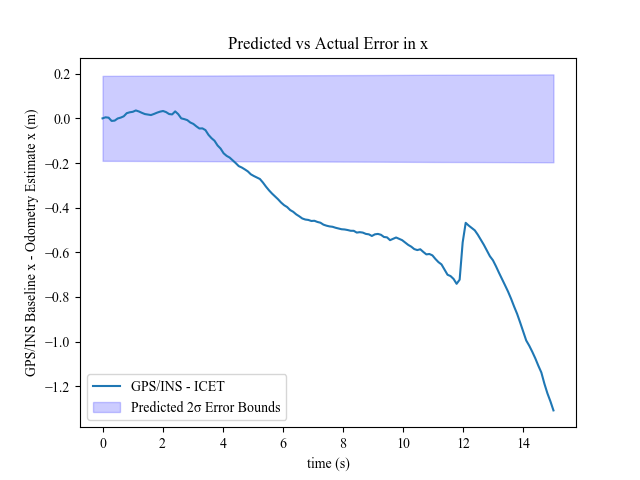

Text(0, 0.5, 'GPS/INS Baseline x - Odometry Estimate x (m)')

In [248]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)

ICET_pred_stds = np.loadtxt("ICET_pred_stds_v7.txt")
# ICET_pred_stds = (2*np.sqrt(ICET_pred_stds))**2

#which component to look at
# c = 5 #yaw
c = 0 # x (forward movement)

diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]
    
#flip sign when looking at yaw
if c ==5:
    diffx = -diffx 
    
cum_err = np.zeros(np.shape(ICET_pred_stds))
cum_diffx = np.zeros(np.shape(diffx))

for i in range(np.shape(ICET_pred_stds)[0]):
    cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
#     cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0005,0.0005,0.001])**2
    cum_err[i,:] += np.sqrt(2)*np.array([0.08,0.08,0.1,0.0005,0.0005,0.001])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 

# # # #old (error for each individual timestep)------------------------
# ax3.plot(diffx, label = 'GPS/INS - ICET')
# ax3.fill_between(np.linspace(0,150,np.shape(ICET_pred_stds)[0]), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
#                  color = (0,0,1,0.2), label = 'ICET Predicted 2σ Error Bounds')
# # # #-------------------------------------------------------------------

#new (accumulated differences in error)--------------------------
# ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx_with_ground, label = 'GPS/INS - ICET')
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET')
ax3.fill_between(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
                 color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')
# --------------------------------------------------------------------

ax3.legend(loc = 'lower left')
ax3.set_title("Predicted vs Actual Error in x")
ax3.set_xlabel("time (s)", **font)
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)", **font)
# ax3.set_ylim([-0.07,0.07])

In [ ]:
#test where points are inside spherical cell...
# print(it.cloud1_tensor_spherical)
maxtheta = tf.constant([[0.2],[0.7]])
maxr = tf.constant([[0.5],[2.]])

ans1 = tf.greater(it.cloud1_tensor_spherical[:,1], maxtheta)
# print(ans1)
ans2 = tf.less(it.cloud1_tensor_spherical[:,0], maxr)
# print(ans2)
combined = tf.Variable([ans1, ans2])
# print(combined)
ans3 = tf.math.reduce_all(combined, axis = 1)

print(ans3)

In [ ]:
#duplicate each element of an n*1 vector 3 times
t = tf.linspace(0,5,6)[:,None]
print(t)

test  = tf.tile(t, [3,1])
# print(test)
test2 = tf.reshape(tf.transpose(tf.reshape(test, [3,-1])), [-1,1])
print(test2)
test3 = tf.reshape(tf.transpose(tf.reshape(test, [3,-1])), [-1,3])
print(test3)

In [ ]:
#duplicate each element of an n*3 vector 3 times
t = tf.linspace(1,4,4)
t = tf.transpose(tf.Variable([t, 2*t, 3*t]))
print(t)

test  = tf.tile(t, [3,1])
# print(test)

test = tf.reshape(tf.transpose(test), [3, 3, -1])
# print(test)

test = tf.transpose(test, [2,1,0])
# print(test)

test = tf.reshape(test, [-1,3])
print(test)
